In [1]:
import matplotlib as plt

In [2]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.metrics import Recall
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from keras import layers
import keras

from sklearn.metrics import recall_score

import numpy as np

In [3]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## Датасет

Прежде чем разбираться с моделями, нам надо в первую очередь разобраться с тем, как грузить датасет. Давайте напишем класс в торче для этого.

In [4]:
# Объявляем переменные файлов и папки
DIR_TRAIN = "../train/train/"
DIR_TEST = "../test/test/"

PATH_TRAIN = "../train/train.csv"
PATH_TEST = "../test/test.csv"

In [5]:
IMG_SIZE = 256

In [6]:
ds_train, ds_test = image_dataset_from_directory(
    DIR_TRAIN,
    subset="both",
    seed=123,
    labels='inferred',
    label_mode='int',
    image_size=[IMG_SIZE, IMG_SIZE],
    batch_size=16,
    interpolation="bilinear",
    shuffle=True,
    validation_split=0.15,
)

Found 4990 files belonging to 8 classes.
Using 4242 files for training.
Using 748 files for validation.


In [7]:
ds_valid = image_dataset_from_directory(
    DIR_TEST,
    labels='inferred',
    label_mode='int',
    image_size=[IMG_SIZE, IMG_SIZE],
    batch_size=16,
    interpolation="bilinear",
    shuffle=False,
)

Found 2138 files belonging to 1 classes.


In [8]:
from tensorflow.keras.layers import RandomContrast, RandomFlip, RandomRotation
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50V2, ResNet152V2
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
# pretrained_base = InceptionV3(weights='imagenet', include_top=False, input_shape=[IMG_SIZE, IMG_SIZE, 3])
# pretrained_base = ResNet152V2(weights='imagenet', include_top=False, input_shape=[IMG_SIZE, IMG_SIZE, 3], classes = 8)
pretrained_base = ResNet50V2(weights='imagenet', include_top=False, input_shape=[IMG_SIZE, IMG_SIZE, 3], classes = 8)
pretrained_base.trainable = False

In [10]:
callback = EarlyStopping(monitor='loss', patience=5, restore_best_weights = True, verbose = True)

In [11]:
model = keras.Sequential([
    
    layers.Rescaling(1./255),

    layers.InputLayer(input_shape=[IMG_SIZE, IMG_SIZE, 3]),
    
    # Data Augmentation
    RandomContrast(factor=0.10),
    RandomFlip(mode='horizontal'),
    RandomRotation(factor=0.10),

    pretrained_base,

    # Head
    # layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    # layers.Dropout(0.5),
    layers.Dense(8, activation='softmax'),
])

In [12]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss = 'SparseCategoricalCrossentropy',
    metrics = ['SparseCategoricalAccuracy']
)

In [13]:
class_weight = {
    0: 0.064329,
    1: 0.317836,
    2: 0.063327,
    3: 0.194188,
    4: 0.159719,
    5: 0.103006,
    6: 0.058717,
    7: 0.038878
}

class_weight_reversed = dict(enumerate((1 - np.array(list(class_weight.values()))) / sum((1 - np.array(list(class_weight.values()))))))

In [15]:
history = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=20, 
    callbacks=[callback],
    class_weight = class_weight
)

Epoch 1/20
266/266 [==============================] - 50s 174ms/step - loss: 0.1066 - sparse_categorical_accuracy: 0.6653 - val_loss: 0.9393 - val_sparse_categorical_accuracy: 0.6845
Epoch 2/20
266/266 [==============================] - 46s 172ms/step - loss: 0.0926 - sparse_categorical_accuracy: 0.6792 - val_loss: 0.8744 - val_sparse_categorical_accuracy: 0.7086
Epoch 3/20
 36/266 [===>..........................] - ETA: 37s - loss: 0.1125 - sparse_categorical_accuracy: 0.6979

KeyboardInterrupt: 

<AxesSubplot:>

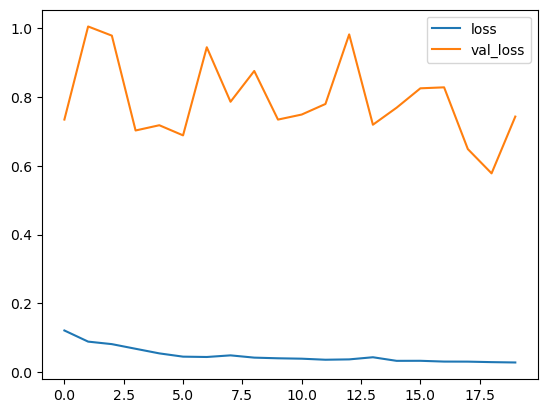

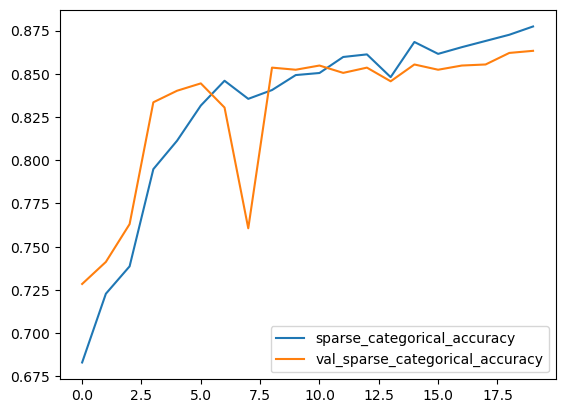

In [ ]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

In [ ]:
print(model.evaluate(ds_test, use_multiprocessing = True))

103/103 [==============================] - 5s 44ms/step - loss: 0.7436 - sparse_categorical_accuracy: 0.8633
[0.7435739636421204, 0.8633049726486206]


In [ ]:
import numpy as np
preds_softmax = model.predict(ds_test, use_multiprocessing=True, callbacks = [callback])
preds = np.argmax(preds_softmax, axis = 1)

103/103 [==============================] - 5s 42ms/step


In [ ]:
targets = []
for batch, target in ds_test:

    targets.extend(target.numpy())

val_recall = recall_score(targets, preds, average = "macro")
print(f"Validation accuracy = {val_recall}")

In [ ]:
files_to_predict = os.listdir(r"D:\ML\cherk\test\test\0")
files_to_predict_sorted = sorted(files_to_predict, key = lambda x: int(x.split('.')[0]))
files_to_predict_sorted[:5]

['0.jpg', '1.jpg', '2.jpg', '3.jpg', '4.jpg']

In [ ]:
predictions = []

for image in files_to_predict_sorted:
    image = load_img(rf"D:\ML\cherk\test\test\0\{image}", 
        target_size=[IMG_SIZE, IMG_SIZE],
        interpolation="bilinear",)
    input_arr = img_to_array(image)   
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    predictions.append(np.argmax(model.predict(input_arr)))

1/1 [==============================] - 0s 23ms/step


In [ ]:
test_preds['class'] = predictions
test_preds

,ID_img,class
0,0.jpg,5
1,1.jpg,5
2,2.jpg,1
3,3.jpg,1
4,4.jpg,6
...,...,...
2133,2133.jpg,4
2134,2134.jpg,1
2135,2135.jpg,1
2136,2136.jpg,3


In [ ]:
test_preds.to_csv("submit_v1_path_correction.csv", index=False)